# <center><font color=	DarkRed>Améliorez le produit IA de votre start-up</font></center><br>

## <center><font color=darkRed>PARTIE 1 - NLP</font></center>

<center>
<img src="../images/avis-resto.png", style="width:300px;height:120px;">
</center>
<br>

In [52]:
import numpy as np
import pandas as pd
import json
import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import emoji

from gensim import models
from gensim.corpora.dictionary import Dictionary

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

# Librairies de visualisation ML
import mlxtend
# print(mlxtend.__version__)

#Afficher toutes les sorties de cellules de code
# IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'last'

from IPython.display import display
#clear_output()
from IPython.display import Image, HTML, Markdown, display

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

#Afficher toutes les sorties de cellules de code
# IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'last'


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Pour la gestion des alertes
import warnings 
from warnings import simplefilter
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

from distutils.version import LooseVersion
from packaging import version;

In [53]:
import fonction;

## <center><font color=darkRed>1. - Chargement des données</font></center>

In [3]:
df_business = pd.read_json('../data/yelp_dataset/yelp_academic_dataset_business.json',lines=True)
df_review = pd.read_json('../data/yelp_dataset/yelp_academic_dataset_review.json',lines=True)

## <center><font color=darkRed>2. - Présentation générale du jeu de données</font></center>

In [4]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


Le fichier est composé de 150 346 établissements.

Je vais trier les données pour ne récupérer que les établissements correspondants aux critères suivants :

- les catégorie non vide
- Les catégorie Restaurant ou une catégorie liée


In [5]:
df_business = df_business[['business_id', 'categories']].dropna(subset=['categories'])

In [58]:
df_business['categories'].apply(lambda x : fonction.count_categories(x));

### <center><font color=darkBlue>2.1 - Création du nouveau jeu de données</font></center>

In [7]:
# je ne garde que les établissements correspondants aux catégories suivantes
selected_categories = ['Restaurants', 'Food', 'Sandwiches', 'Pizza', 'Fast Food', 'Breakfast & Brunch', 'Burgers', 'Mexican', 'Italian', 'Seafood', 
'Chinese', 'Chicken Wings', 'Japanese', 'Sushi Bars', 'Barbeque', 'Steakhouses', 'Food Trucks', 'Mediterranean', 'Donuts', 'Soup', 'Tacos', 'Thai', 
'Tex-Mex', 'Vietnamese', 'Indian', 'Greek', 'Hot Dogs', 'Bagels', 'Cheesesteaks', 'French', 'Korean']

In [59]:
df_business = df_business[df_business['categories'].apply(lambda x : fonction.check_cat(x, selected_categories))]

Il reste 64577 établissements

Le jeu de données contient 6 990 280 avis.

In [10]:
df_review = df_review[['business_id', 'stars', 'text']]

In [60]:
df_final = df_business.merge(df_review, how='left', on='business_id', validate='1:m')
df_final.head(5)

,business_id,categories,stars,text
0,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4,This is nice little Chinese bakery in the hear...
1,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4,This is the bakery I usually go to in Chinatow...
2,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",5,"A delightful find in Chinatown! Very clean, an..."
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",5,I ordered a graduation cake for my niece and i...
4,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...


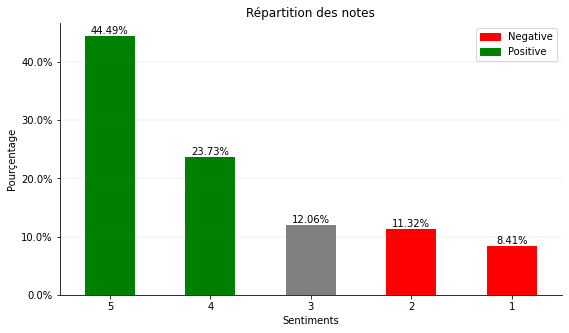

In [12]:
fonction.plot_ratings_dist(df_final)

je vais créer deux nouveaux dataset: 
- **bad_reviews** : commantaires de moins de 2 etoiles
- **good_reviews** : commantaires de plus de 3 etoiles

In [13]:
bad_reviews = df_final[df_final.stars <= 2]
good_reviews = df_final[df_final.stars >= 3]

In [14]:
bad_reviews.shape

(1048829, 4)

Il nous reste donc au final 1.048829 avis, correspondants à des établissements de type restaurant, et noté 2 étoiles ou moins.

je sauvegarde les jeux de données dans un fichier csv, qui seront utilisé dans le notebook NLP

### <center><font color=darkBlue>2.2 - Enregistrement des jeux de données</font></center>

In [15]:
bad_reviews.to_csv('../data/bad_reviews.csv', index=False)
good_reviews.to_csv('../data/good_reviews.csv', index=False)

## <center><font color=darkRed>3. - Preprocessing</font></center>

Le but de cette partie est d'identifier quel sujet sont abordé dans les mauvaises critiques.

Nous appelons cela la modélisation des sujets car il s'agit d'une technique permettant d'extraire les sujets cachés de gros volumes de texte.

Pour cela,je vais utiliser plusieurs bibliothèques Python open-source gratuites, pour la **tokenisation**, le **stemming/lemmatisation**, le **tagging**, la **classification**, etc. :

- <strong>Gensim</strong>,
- <strong>NLTK</strong>,
- <strong>Spacy</strong>.

### <center><font color=darkBlue>3.1 - Nettoyage et analyse des Commentaires</font></center>

Je commence par recuperer le dataset créer via l'API, puis je le fusionne au dataset créer ci dessus <strong>bad_reviews</strong>

In [16]:
bad_reviews = pd.read_csv('../data/bad_reviews.csv', sep=',')
bad_reviews_api = pd.read_csv('../data/bad_reviews_from_api.csv', sep=',')
bad_reviews_api.shape

(200, 4)

In [17]:
merge_bad_reviews = pd.concat([bad_reviews, bad_reviews_api])
merge_bad_reviews = merge_bad_reviews[merge_bad_reviews.stars <= 2]

Afin de limiter le temps de calcul, je ne garde que 50 000 commentaires tirée aleatoirement

In [18]:
sample_reviews = merge_bad_reviews.sample(n = 50000)
sample_reviews.head()

,business_id,categories,stars,text
395405,F0Q9o6yuYh8f0DYl1RFjxQ,"Breakfast & Brunch, Bars, American (New), Rest...",1,"This is not about the food, as I didn't get to..."
646424,t81dbgfs0gNVflIRRP1XRA,"Indian, Restaurants",2,So we decided to give this place a second try!...
421660,zwcWzqineLPY4qDhCJ2Jtw,"American (Traditional), Bars, Restaurants, Nig...",1,Ordered 6 naked wings with lemon pepper. Gross...
803665,TeP60DIUUa6VQuvCEvoTsw,"Bakeries, Restaurants, Food, Cupcakes, Delis, ...",2,Disappointed. Went there for breakfast. Part...
468762,gOrJeoLDOiW7muWuoE-sMg,"Restaurants, Nightlife, Arts & Entertainment, ...",2,"Beautiful restaurant, wish the service was as ..."


#### <center><font color=darkGreen>3.1.1 - Tokenisation</font></center>

Je vais effectuer la tokenisation grace à la pipelaine **<code>preprocess_nlp</code>** *avec le paramètre <code>tokenize</code> sur <font color=darkGreen><strong>True</strong></font>* qui va me permettre de nettoyer les commentaires du dataset :

- Remplacement des emojis par son équivalent en mot
- Suppression de la ponctuation et des nombres
- Mettre le texte en minuscule
- Tokenizer notre texte (un token = 1 mot, chaque commentaires est donc sous la forme d'un tableau de mots (de tokens))

In [19]:
corpus = fonction.preprocess_nlp(sample_reviews['text'], sample_reviews, tokenize=True, lemmatize=False)

In [20]:
# Calcul des fréquences des mots dans chaque texte
freq = []
for row in corpus:
    freq.append(nltk.FreqDist(row))

# Fréquence totale de chaque mot pour l'ensemble du corpus
freq_totale = nltk.Counter()
for fr in freq:
    freq_totale += fr

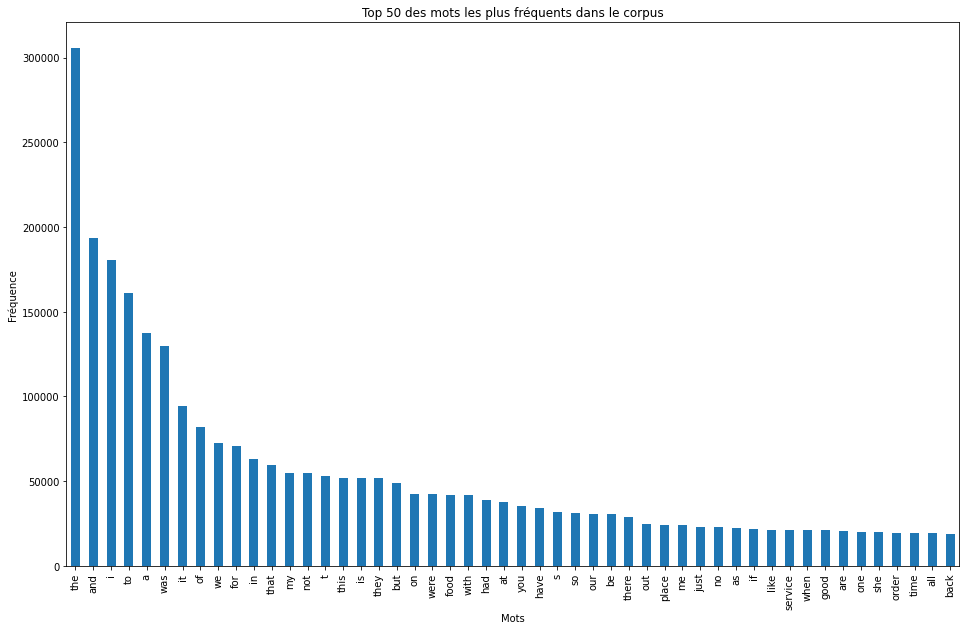

In [21]:
fonction.word_freq_hist(freq_totale, 50)

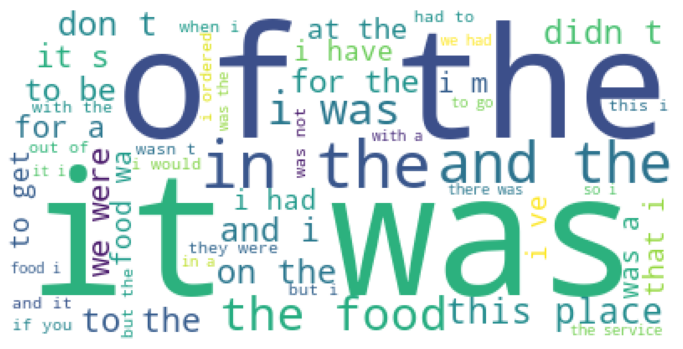

In [22]:
fonction.wordcloud(corpus, 50)

#### <center><font color=darkGreen>3.1.2 - StopWords et lemmatisation</font></center>

je vais procéder à un second nettoyage à l'aide de la pipeline **<code>preprocess_nlp</code>** *avec le paramètre <code>lemmatize</code> sur <font color=darkGreen><strong>True</strong></font>* qui permet de :

- Supprimer les stop words (les mots communs qui n'ont pas de sens) consiste a supprimer les jetons qui appartiennent à une liste de mots vides (ex. : "le", "un", "de", ...)
- Supprimer les mots de 3 lettres ou moins
- Lemmatiser (récupérer la forme neutre canonique des mots)

In [23]:
corpus_lem = fonction.preprocess_nlp(sample_reviews['text'], sample_reviews, tokenize=True, lemmatize=True)

In [24]:
# Calcul des fréquences des mots dans chaque texte
freq_lem = []
for row in corpus_lem:
    freq_lem.append(nltk.FreqDist(row))

# Fréquence totale de chaque mot pour l'ensemble du corpus
freq_totale_lem = nltk.Counter()
for fr in freq_lem:
    freq_totale_lem += fr

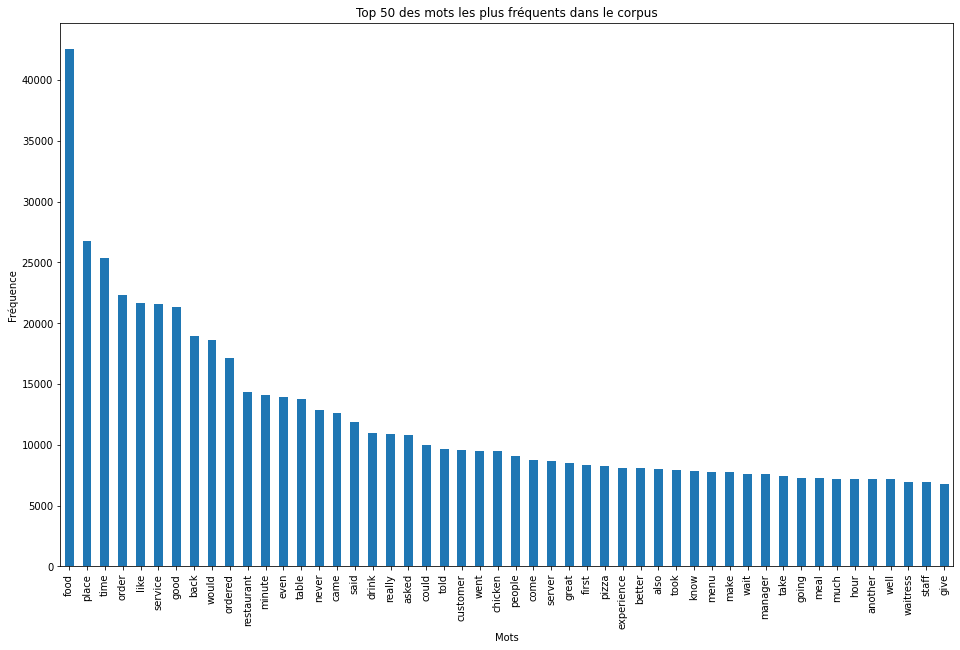

In [25]:
fonction.word_freq_hist(freq_totale_lem, 50)

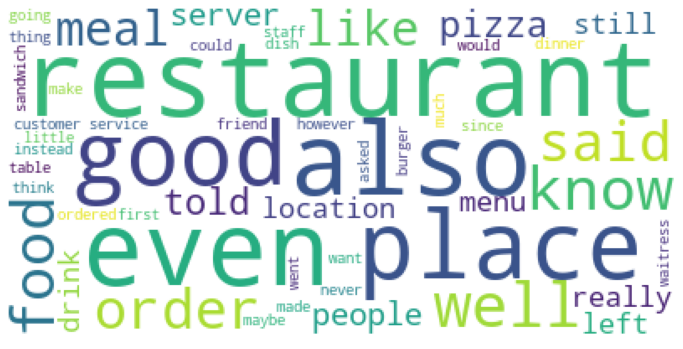

In [26]:
fonction.wordcloud(corpus_lem, 50)

Après ce second nettoyage, la tokenisation a déjà beaucoup plus de sens. Les mots les plus fréquents peuvent être associés à un sujet.

Cela nous donne également un aperçu de ce qui ressort le plus souvent dans les mauvais commentaires.



#### <center><font color=darkGreen>3.1.3 - Vectorisation</font></center>

la vectorisation consiste a transformer une liste de jetons en un vecteur de caractéristiques, avec plus ou moins de traitement des jetons

je vais créer une matrice de taille **<code>"nombres de commentaires * taille du vocabulaire"</code>** suivant les 2 méthodes suivante:

- <code><strong>CountVectorizer</strong></code> : (*compte simplement les occurrences de jetons dans chaque document du corpus*), ici je vais calculer la fréquence d'apparition des différents mots de tous le vocabulaire pour chaque commentaire
- <code><strong>TfidfVectorizer</strong></code> : (*compte les occurrences de jeton dans chaque document du corpus puis calcule la fréquence de document inverse (IDF) de chaque jeton (si un jeton est présent dans chaque document, il n'est pas spécifique à un document et son IDF sera faible)*)
ici je vais calculer un rapport entre la fréquence d'apparition des mots dans le commentaires et dans le corpus total et ce pour chaque commentaires 

Ces matrices sont ensuites utilisées par nos algorithmes pour faire par exemple de la modélisation de sujet ***(Topic modeling)***.

J'effectue cette vectorisation à titre d'exemple, car les algorithmes de la librairie Gensim que je vais utiliser par la suite, incluent déjà la vectorisation dans leur pipeline.

In [54]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')
lemmatizer = WordNetLemmatizer()


def tokenize(text):
    #tokens = tokenize_text(text)
    tokens = tokenizer.tokenize(emoji.demojize(text, delimiters=("", "")).lower())
    return [lemmatizer.lemmatize(w) for w in tokens if w not in stopwords and len(w) > 3];

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlenehourdin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Countvectorizer avec une reduction de dimension de 1000 mots

In [28]:
cv = CountVectorizer(tokenizer=tokenize, stop_words=stopwords, ngram_range=(1, 1), max_features=1000)
data_cv = cv.fit_transform(sample_reviews['text'])
data_cv_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_cv_dtm.index = sample_reviews.index
data_cv_dtm


,able,absolutely,across,actual,actually,added,additional,afternoon,ahead,almost,...,would,wrap,write,wrong,yeah,year,yelp,yesterday,young,zero
395405,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
646424,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
421660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
803665,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
468762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556954,0,1,0,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,0
320777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TfidfVectorizer sans reduction de dimension

In [29]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stopwords)
data_tfidf = tfidf.fit_transform(sample_reviews['text'])
data_tfidf_dtm = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names_out())
data_tfidf_dtm.index = sample_reviews.index
data_tfidf_dtm

,aaaaaa,aaaaaaand,aaaaand,aaaand,aaaanndd,aaaannnnnddd,aaaarrggghhh,aaah,aaahhh,aaannnnddddd,...,zuppa,zurich,zwickel,zwickels,zwickle,zwieback,zydeco,zydego,zzzz,zzzzzz
395405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
646424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
803665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
468762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <center><font color=darkRed>4. - LDA (Latent Dirichlet Allocation)</font></center>

### <center><font color=darkBlue>4.1 - 4 Topics</font></center>

On veut identifier des sujets à partir des commentaires pour essayer de comprendre ce qui rend les clients insatisfaits.

je vais utiliser la technique **LDA** ***(Laten Dirichlet Allocation)***, qui est un modèle probabiliste génératif qui permet de décrire des collections de documents de texte ou d'autres types de données discrètes. LDA fait partie d'une catégorie de modèles appelés **"topic models"** , qui cherche à découvrir des structures thématiques cachées dans de vastes archives de documents.

Ceci permet d'obtenir des méthodes efficaces pour le traitement et l'organisation des documents de ces archives : organisation automatique des documents par sujet, recherche, compréhension et analyse du texte, ou même résumé des textes.

In [30]:
# Créer un corpus à partir d'une liste de textes
common_dictionary = Dictionary(corpus_lem)
common_corpus = [common_dictionary.doc2bow(text) for text in corpus_lem]

Cet algorithme prend en entrée un hyperparamètre "num_topics" permettant de définir le nombre de topics que l'on veut extraire.

Il est possible d'identifier un nombre idéal de topics, a l'aide d'un score de coherence que l'on verra plus loin.

Je commence ici avec 4 topics.

In [31]:
lda = models.LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=4)
lda.print_topics()


[(0,
  '0.014*"place" + 0.011*"restaurant" + 0.011*"food" + 0.009*"like" + 0.007*"good" + 0.007*"would" + 0.006*"room" + 0.005*"people" + 0.005*"staff" + 0.005*"table"'),
 (1,
  '0.019*"food" + 0.016*"minute" + 0.015*"table" + 0.013*"time" + 0.013*"service" + 0.012*"drink" + 0.012*"order" + 0.012*"came" + 0.012*"back" + 0.011*"asked"'),
 (2,
  '0.017*"food" + 0.014*"good" + 0.013*"ordered" + 0.013*"like" + 0.011*"chicken" + 0.011*"place" + 0.008*"sauce" + 0.007*"cheese" + 0.006*"salad" + 0.006*"really"'),
 (3,
  '0.019*"time" + 0.019*"order" + 0.016*"food" + 0.012*"service" + 0.012*"place" + 0.011*"customer" + 0.009*"pizza" + 0.008*"back" + 0.008*"would" + 0.007*"never"')]

In [32]:
# Perplexité
print('\nPerplexité: ', lda.log_perplexity(common_corpus))  #une mesure de la qualité du modèle. plus c'est bas, mieux c'est.

# Coherence Score
coherence_model_lda = models.CoherenceModel(model=lda, texts=corpus_lem, dictionary=common_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexité:  -7.50336673962417

Coherence Score:  0.38724452755800765


In [33]:
# Visualisation des topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, common_corpus, common_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.165967  0.016464       1        1  32.302283
1      0.071589  0.041322       2        1  28.272957
3      0.059306  0.074312       3        1  22.194006
0      0.035071 -0.132098       4        1  17.230754, topic_info=         Term          Freq         Total Category  logprob  loglift
183     order  22020.000000  22020.000000  Default  30.0000  30.0000
112    minute  14184.000000  14184.000000  Default  29.0000  29.0000
369   chicken   9458.000000   9458.000000  Default  28.0000  28.0000
24      table  13539.000000  13539.000000  Default  27.0000  27.0000
1171    sauce   6453.000000   6453.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
67     review   1418.306215   6143.832756   Topic4  -5.7555   0.2925
111      menu   1446.179906   7770.138950   Topic4  -5.7360   0.0771
267      much   1420.560193   7325.388770   Topic4  -5.7539   0.1182
256      back   1287.637140  19061.736823   Topic4  -5.8522  -0.9364
533     price   1239.542537   5701.497241   Topic4  -5.8902   0.2325

[400 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
295       1  0.015625      abruptly
295       2  0.984369      abruptly
7608      3  0.982776     accepting
2714      1  0.003398  acknowledged
2714      2  0.982002  acknowledged
...     ...       ...           ...
353       4  0.173880          work
57        1  0.237852         would
57        2  0.364424         would
57        3  0.237308         would
57        4  0.160473         would

[1031 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

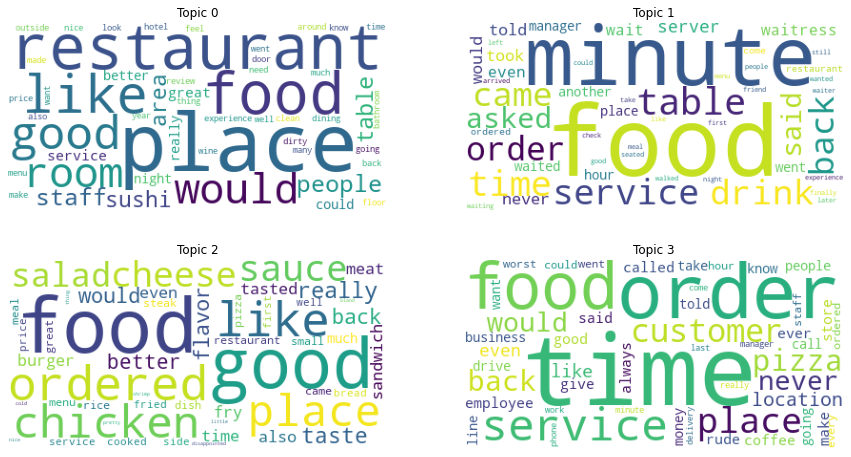

In [34]:
# On affiche le nuage de mots de chaque topic
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(fonction.WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()

Avec cette technique et à l'aide des graphiques on peut donc identifier à quoi correspondent les 4 topics :

**- Topic 0 :** place, restaurant, food, room, people, staff, table, service, experience, price ***(Le service ?)***  
**- Topic 1 :** food, minute, table, time, service, drink, order, waitress, arrived, hour ***(Le temps de service et le personnel ?)***  
**- Topic 2 :** food, ordered, chicken, place, sauce, cheese, salad, flavor, taste, sandwich ***(la nourriture ?)***  
**- Topic 3 :** time, order, food, service, place, customer, pizza, location, employee, delivery ***(Delais de livraison ? )***  


Je pourrait améliorer la précision en supprimant certains mots qui ne sont pas utiles dans la modelisation de sujet.

Je vais garder seulement les noms en utilisant la fonction **<code>pos_tag</code>** de NLTK ***(balisage POS 'NN' = Nom commun)*** 


In [35]:
corpus_lda = fonction.preprocess_nlp(sample_reviews['text'], sample_reviews, tokenize=False, lemmatize=True)

In [36]:
# On garde seulement les noms
corpus_cleaned = []
for element in corpus_lda:
    pos_tag = nltk.pos_tag(element)
    if len(pos_tag) > 1:
        pos_tag_cleaned = list(zip(*[word for word in pos_tag if word[1] == 'NN']))
        if len(pos_tag_cleaned) > 1 :
            corpus_cleaned.append(list(pos_tag_cleaned[0]))

# Calcul des fréquences des mots dans chaque texte
freq_lda = []
for row in corpus_cleaned:
    freq_lda.append(nltk.FreqDist(row))

# Fréquence totale de chaque mot pour l'ensemble du corpus
freq_totale_lda = nltk.Counter()
for fr in freq_lda:
    freq_totale_lda += fr

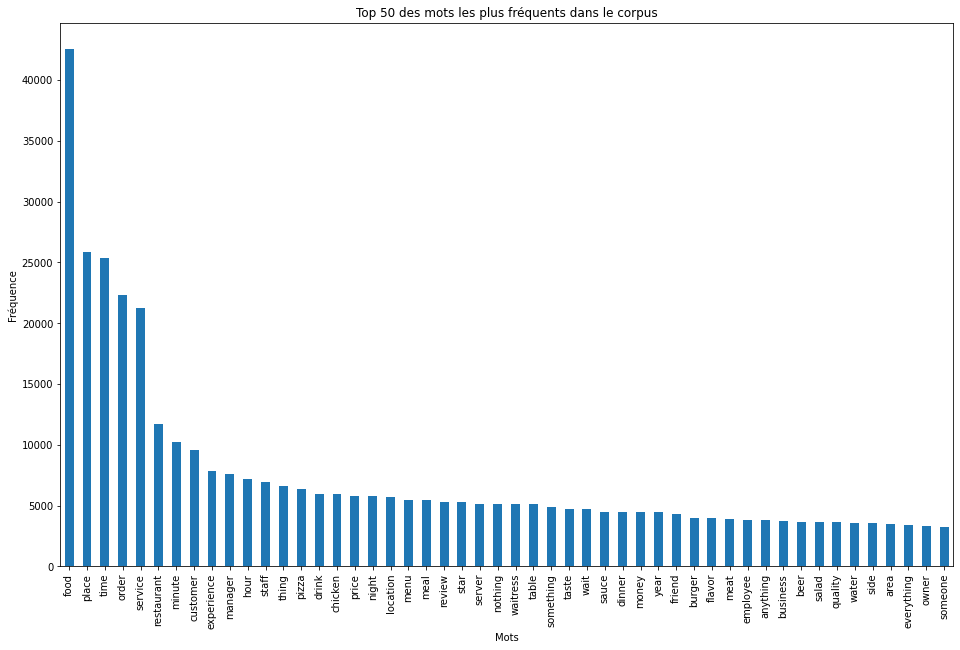

In [37]:
fonction.word_freq_hist(freq_totale_lda, 50)

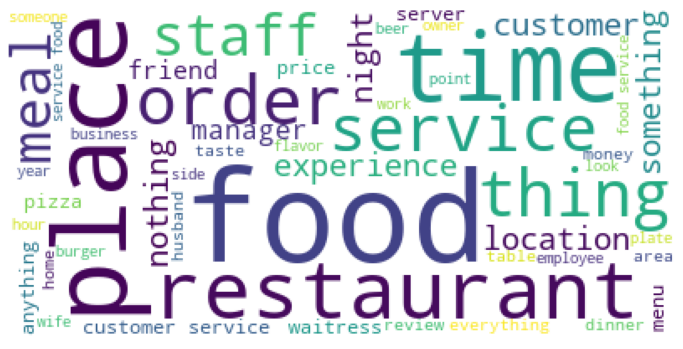

In [38]:
fonction.wordcloud(corpus_cleaned, 50)

### <center><font color=darkBlue>4.2 - Score de coherence</font></center>

Ici je vais calculer le <strong>score de coherence</strong> : 

- Nous pouvons utiliser le score de cohérence dans la modélisation des sujets pour mesurer à quel point les sujets sont interprétables pour les humains. Dans ce cas, les sujets sont représentés par les N premiers mots ayant la probabilité la plus élevée d'appartenir à ce sujet particulier. 

*<strong>A noter</strong>, le score de cohérence mesure à quel point ces mots sont similaires les uns aux autres*

In [39]:
# Calcul le coherence score pour plusieurs valeurs de l'hyperparamètres num_topic
def compute_coherence_values(dictionnary, corpus, texts):

    coherences_values = []
    model_list = []

    for num_topic in range(2, 15, 1):
        model = models.LdaModel(corpus=corpus, id2word=dictionnary, num_topics=num_topic)
        model_list.append(model)

        coherence_model = models.CoherenceModel(model=model, texts=texts, dictionary=dictionnary, coherence='c_v')
        coherences_values.append(coherence_model.get_coherence())
    
    return model_list, coherences_values

Ici je vais créer un corpus (sac de mot *(bag of word)*), *c’est le corpus qui contient le mot id et sa fréquence dans chaque document.*  
Je calcul ensuite le score de coherence de 0 à 15 Topic

In [55]:
# Créer un corpus à partir d'une liste de textes
common_dictionary = Dictionary(corpus_cleaned)
common_corpus = [common_dictionary.doc2bow(text) for text in corpus_cleaned]

model_list, coherence_values = compute_coherence_values(common_dictionary, common_corpus, corpus_cleaned);

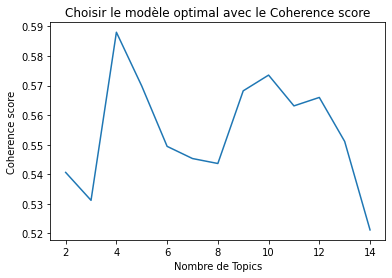

In [41]:
# Graphe d'évolution du coherence score
x = range(2, 15, 1)
plt.plot(x, coherence_values)
plt.xticks(range(2, 15, 2))
plt.xlabel("Nombre de Topics")
plt.ylabel("Coherence score")
plt.title("Choisir le modèle optimal avec le Coherence score")
plt.show()

In [42]:
# Display Coherence scores with 4 decimals
for m, cv in zip(x, coherence_values):
    print('Number of Topics= ', m, " has Coherence Value of", round(cv, 4))

Number of Topics=  2  has Coherence Value of 0.5406
Number of Topics=  3  has Coherence Value of 0.5312
Number of Topics=  4  has Coherence Value of 0.588
Number of Topics=  5  has Coherence Value of 0.5698
Number of Topics=  6  has Coherence Value of 0.5494
Number of Topics=  7  has Coherence Value of 0.5453
Number of Topics=  8  has Coherence Value of 0.5436
Number of Topics=  9  has Coherence Value of 0.5682
Number of Topics=  10  has Coherence Value of 0.5735
Number of Topics=  11  has Coherence Value of 0.5631
Number of Topics=  12  has Coherence Value of 0.566
Number of Topics=  13  has Coherence Value of 0.5511
Number of Topics=  14  has Coherence Value of 0.5212


La différence de coherence score en fonction du nombre de topics n'est pas si grande. Elle augmente à partir de 4 et commence à chuter après une dizaine de topics (12 et 14).

***Pour la suite je vais prendre un nombre de topics à 4.***

In [43]:
lda = model_list[2]
lda.print_topics()

[(0,
  '0.032*"food" + 0.024*"service" + 0.018*"drink" + 0.015*"table" + 0.015*"restaurant" + 0.015*"server" + 0.014*"waitress" + 0.014*"beer" + 0.014*"time" + 0.013*"experience"'),
 (1,
  '0.037*"food" + 0.024*"place" + 0.016*"chicken" + 0.013*"sauce" + 0.012*"taste" + 0.012*"restaurant" + 0.012*"flavor" + 0.011*"meat" + 0.010*"salad" + 0.010*"price"'),
 (2,
  '0.061*"food" + 0.046*"order" + 0.046*"time" + 0.042*"place" + 0.034*"service" + 0.020*"minute" + 0.018*"pizza" + 0.014*"customer" + 0.013*"hour" + 0.011*"restaurant"'),
 (3,
  '0.023*"order" + 0.023*"time" + 0.021*"customer" + 0.018*"store" + 0.014*"phone" + 0.012*"business" + 0.012*"delivery" + 0.012*"card" + 0.011*"manager" + 0.010*"employee"')]

In [44]:
# Perplexité
print('\nPerplexité: ', lda.log_perplexity(common_corpus))  # a measure of how good the model is. lower the better.

# Coherence Score
coherence_model_lda = models.CoherenceModel(model=lda, texts=corpus_cleaned, dictionary=common_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexité:  -6.94657910230375

Coherence Score:  0.5880234903972538


In [45]:
# Visualisation des topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, common_corpus, common_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.202934  0.079196       1        1  30.790560
2      0.021390 -0.009753       2        1  30.604059
0      0.002694 -0.162924       3        1  22.641391
3      0.178850  0.093481       4        1  15.963990, topic_info=         Term          Freq         Total Category  logprob  loglift
77      order  21428.000000  21428.000000  Default  30.0000  30.0000
128     pizza   6092.000000   6092.000000  Default  29.0000  29.0000
1    customer   9371.000000   9371.000000  Default  28.0000  28.0000
115     store   3134.000000   3134.000000  Default  27.0000  27.0000
117      time  25136.000000  25136.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
4        hour   1158.363749   6990.664994   Topic4  -5.0074   0.0373
46    service   1339.925878  20726.659343   Topic4  -4.8618  -0.9040
21      place   1269.042717  25036.662683   Topic4  -4.9161  -1.1472
40      staff    951.747923   6738.756795   Topic4  -5.2039  -0.1225
295      year    914.572878   4381.929259   Topic4  -5.2437   0.2680

[362 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1861      1  0.004940     account
1861      2  0.024701     account
1861      3  0.009880     account
1861      4  0.963346     account
1513      3  0.984650  adjustment
...     ...       ...         ...
295       3  0.249205        year
295       4  0.208812        year
1243      1  0.006384      yogurt
1243      2  0.006384      yogurt
1243      4  0.989484      yogurt

[809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

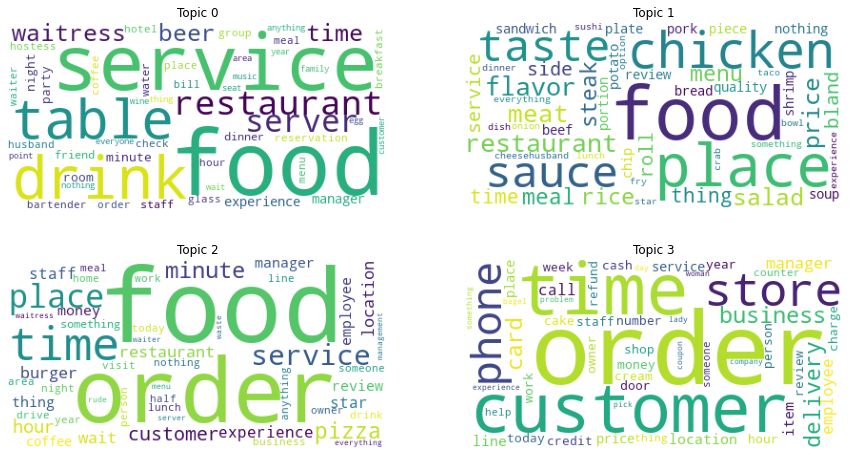

In [46]:
# j'affiche les nuages de mots de chaque topic
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(fonction.WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()

Voici à quoi correspondent les 4 topics :

**- Topic 0 :** food, service, drink, table, restaurant, server, waitress, beer, time, experience ***(Le service ?)***  
**- Topic 1 :** food, place, chicken, sauce, taste, restaurant, flavor, meat, salad, price  ***(La Nourriture et le prix ?)***  
**- Topic 2 :** food, order, time, place, service, minute, pizza, customer, hour, restaurant ***(Le lieu et le temps de service ?)***  
**- Topic 3 :** order, time, customer, store, phone, business, delivery, card, manager, employee ***(Commande et temps ?)***  

## <center><font color=darkRed>5. - Reduction de dimension TFIDF</font></center>

J'effectue une reduction de dimention à l'aide de la méthode <code>**TfidfVectorizer**</code> je vais garder les 1000 mots les plus frequents.

Cette methode permet egalement de détecter les sujets d’insatisfaction en affichants les 50 mots les plus fréquents dans le corpus

In [47]:
from collections import Counter

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stopwords, ngram_range=(1, 1), max_features=1000)
data_tfidf = tfidf.fit_transform(sample_reviews['text'])

grams=list(tfidf.get_feature_names())
counts = data_tfidf.sum(axis=0).A1

freq_distribution = Counter(dict(zip(grams, counts)))

In [48]:
value=sum(freq_distribution.values())
for item, count in freq_distribution.items():
    freq_distribution[item]+=30 
    freq_distribution[item]/= value

In [56]:
top10=[item[0] for item in freq_distribution.most_common(10)]

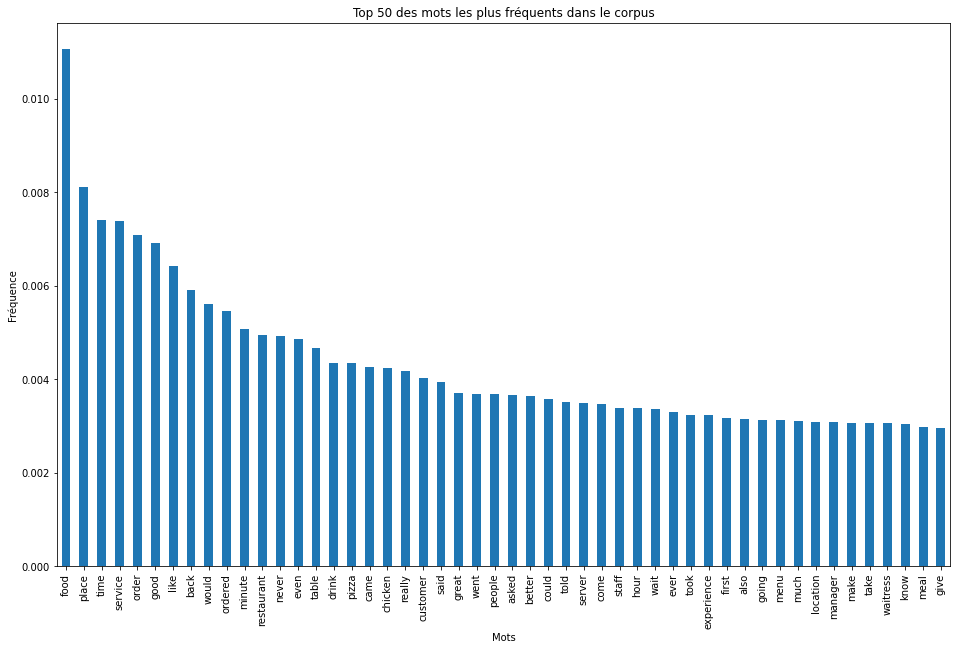

In [51]:
fonction.word_freq_hist(freq_distribution, 50)

## <center><font color=darkRed>6. - Conclusion</font></center>

Apres l'analyse des topics de la <strong>methode LDA</strong> et l'analyse de la <strong>methode TFIDF</strong>, nous pouvons conclure que globalement les clients sont insatisfaits à propos de :

<strong>- La nourriture</strong>  
<strong>- Du restaurant</strong>  
<strong>- Du service</strong>  
<strong>- Du temps de service</strong>  
<strong>- Du personnel</strong>  
<strong>- La propreté</strong>  
<strong>- Du prix</strong>  

Il n'est <strong>pas toujours évident de comprendre les classifications faites par un modèle LDA</strong>, mais cela donne une idée approximative de l'insatisfaction des clients.

<strong>L'API Yelp est trop limitée</strong>, en effet l'API limite chaque établissement à 3 avis et ne fournit que des extraits d'avis. Les utilisateurs peuvent effectuer 5 000 appels d'API par 24 heures